In [1]:
#Brian Shula, 2024

# Second Order ODE for spring-mass-damper system

Boyce and DiPrima - Elementary Differential Equations and Boundary Value Problems, 7th Edition,
Section 3.8, Example 3.

Consider a spring-mass-damper system described by:

u'' + 0.125u' + u = 0, 

where m = 1.0 lb and k = 1 lb/ft.

Initial Conditions:

u(0) = 2, 
u'(0) = 0

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dropout, Dense, LeakyReLU, Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Sequential

In [3]:
#Array of time points
t = np.linspace(0, 50, 1000)

In [4]:
def exact_sol(x):
    #Exact Solution
    omega = np.sqrt(255/256)
    return np.exp(-x / 16) * (2 * np.cos(omega * x) + (2 / np.sqrt(255)) * np.sin(omega * x) )

In [5]:
#get solution values
u = exact_sol(t)

# Solve Numerically using SciPy

Solve a system of first-order ODEs using scipy.integrate.solve_ivp:

Let x1 = u and x2 = u'.  Then, x2' = u''.

The original equation can be rewritten in terms of x1 and x2:

x1' = u''

x2' = -0.125 * x2 - x1, 

with x1(0) = 2 and x2(0) = 0.

In [6]:
#Funciton for evalation: returns coefficients matrix multiplied by [x1, x2].T in system
def odesol(x, Y):
    return [Y[1], -Y[0] - 0.125 * Y[1]]
    

In [7]:
#Timespan for numerical integration
tspan = [t.min(), t.max()]

#Initial conditions for x1, x2
u_init = [2. , 0.]

#Perform numerical integration
sol = solve_ivp(odesol, tspan, u_init, method='RK45', t_eval=t)

Text(0.5, 1.0, 'Numerical and Exact Solutions for the Spring-Mass-Damper System')

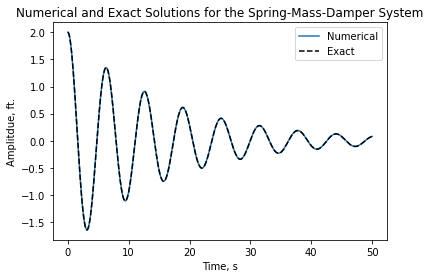

In [8]:
#Plot Numerical and Exact solutions
plt.plot(t, sol.y[0], label='Numerical')
plt.plot(t, u, 'k', ls='--', label='Exact')
plt.legend()
plt.xlabel('Time, s')
plt.ylabel('Amplitdue, ft.')
plt.title('Numerical and Exact Solutions for the Spring-Mass-Damper System')

# PINN Data Preparation 
Solution Data is prepared by defining the time range and number of data points.  The solution data is generated from the numerical solution defined above.  Train and Test sets are split from the data and converted to Tensforflow Datasets and shuffled.  The data points are also plotted. 

In [9]:
#Setup for data and collocation points
tmin = 0
tmax = 50
ndata = 500
ncoll = 1000

In [10]:
#input and solution values
t_data = np.linspace(tmin, tmax, ndata)
u_data = solve_ivp(odesol, [0, tmax], u_init, method='RK45', t_eval=t_data)

In [11]:
#Store inputs-outputs in single array so pairs are kept when shuffled
data = np.column_stack((u_data.t, u_data.y[0]))

#Random shuffle - shuffle times for random order in training batches
rng = np.random.default_rng()
rng.shuffle(data)

In [12]:
#Training data sets
t_train = data[:int(0.9*ndata), 0]
t_test = data[int(0.9*ndata):, 0]

u_train = data[:int(0.9*ndata), 1]
u_test = data[int(0.9*ndata):, 1]

In [13]:
#Tensorflow Tensors and Datasets

#Training Data
t_train_data = tf.convert_to_tensor(t_train[..., tf.newaxis], dtype=tf.float32)
u_train_data = tf.convert_to_tensor(u_train[..., tf.newaxis], dtype=tf.float32)
train_ds_data = tf.data.Dataset.from_tensor_slices((t_train_data, u_train_data)).shuffle(10*ndata).batch(64)

#Test Data
t_test_data = tf.convert_to_tensor(t_test[..., tf.newaxis], dtype=tf.float32)
u_test_data = tf.convert_to_tensor(u_test[..., tf.newaxis], dtype=tf.float32)
test_ds_data = tf.data.Dataset.from_tensor_slices((t_test_data, u_test_data)).shuffle(10*ndata).batch(64)

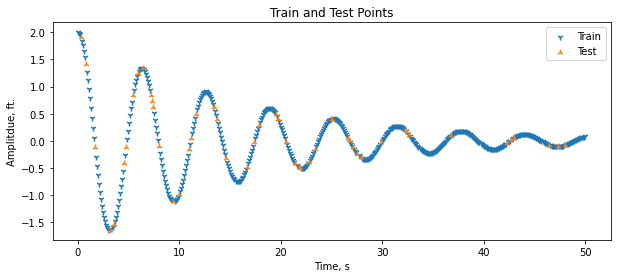

In [14]:
#Plot Training and Test Datasets
plt.subplots(figsize=(10, 4))
plt.scatter(t_train, u_train, marker='1', label='Train')
plt.scatter(t_test, u_test, marker='2', label='Test')

plt.xlabel('Time, s')
plt.ylabel('Amplitdue, ft.')
plt.title('Train and Test Points')
plt.legend()

# PINN Model Setup

## Physics Loss Function
The Physics Loss Function calculates u' and u'' w.r.t. t for the collocation points. The residual is calculated from the original ODE, where u'' + 0.125*u' + u = 0.

In [15]:
@tf.function
def physics_loss(tcoll_loss, inputs, outputs, training):
    with tf.GradientTape() as tape2:
        tape2.watch(tcoll_loss)
        with tf.GradientTape() as tape1:
            tape1.watch(tcoll_loss)
            u_pred = model(tcoll_loss, training=training)

        #calculate gradients
        dudt = tape1.gradient(u_pred, tcoll_loss)
    d2udt2 = tape2.gradient(dudt, tcoll_loss)

    #Residuals based on original Eqn.
    #d2udt2 + 0.125*dudt + u = 0
    res = d2udt2 + 0.125*dudt + u_pred
    
    #PINN loss
    loss=tf.reduce_mean(tf.keras.losses.mean_squared_error(res, tf.zeros_like(res)))
    
    return loss

## Training Function controls model weight updates
The Training Function updates model weights based on the calculated Loss. The Loss is made up of Data Loss, Initial Conditions Loss, and Loss calculated from derivatives on the ODE (PINN loss).

In [16]:
@tf.function
def train_step(tcoll_loss, inputs, outputs):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)
        
        #ODE Loss
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        PINN_loss = physics_loss(tcoll_loss, inputs, outputs, training=True)

        #Data loss
        predictions = model(inputs, training=True)
        data_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(outputs, predictions))
        
        #Initial Conditions loss u(0) = 2.0
        u_init = tf.constant([0], dtype=tf.float32)
        pred_init = model(u_init, training=True)
        ic_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(tf.constant([2.0], dtype=tf.float32), pred_init))
        
        #Combined loss
        total_loss = PINN_loss + data_loss + ic_loss

    #Update model weights    
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(total_loss)

## Test Function monitors model performance on unseen data

The Test Function is similar to the Training Function, except gradients are not calculated and weights are not updated.

In [17]:
@tf.function
def test_step(tcoll_loss, inputs, outputs):

    #PINN loss
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    PINN_loss = physics_loss(tcoll_loss, inputs, outputs, training=False)
    
    #Data loss
    predictions = model(inputs, training=False)
    data_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(outputs, predictions))
    
    #Initial Conditions loss u(0) = 0
    u_init = tf.constant([0], dtype=tf.float32)
    pred_init = model(u_init, training=True)
    ic_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(tf.constant([2.0], dtype=tf.float32), pred_init))
    
    #Combined Loss
    total_loss = PINN_loss + data_loss + ic_loss

    test_loss(total_loss)

## PINN Definition

The model is set up with 2 hidden layers containing 100 neurons each.

In [18]:
#Metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#Define Optimizer - Adam optimizer with initial learning rate
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

#Neural Network construction
input_size = 1
output_size = 1

#Number of Neurons in hidden layers
n_neurons=100

#Activation
act='tanh'

#Fully-connected NN with Dense layers
model=Sequential([
    Dense(n_neurons, activation=act, input_shape=(input_size,)),
    Dense(n_neurons, activation=act),
    Dense(n_neurons, activation=act),
    Dense(output_size, activation='linear'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________


In [19]:
#Compile model
model.compile(optimizer=optimizer)

In [20]:
#Learning Rate Decay
def lr_exp_decay(epoch, lr):
    #Start decay after specified epochs where default training rate is effective
    start=200
    if epoch > start:
        k = 0.0005
        lr=1.0 * lr * np.exp(-k*(epoch-start))
        #maintain minimum learning rate
        if lr<0.0001:
            lr=0.0001
    else:
        lr=0.001

    return lr

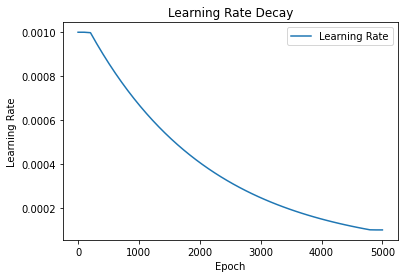

In [21]:
#Plot LR Decay
e = np.linspace(0,5000)

#lr_exp_decay not set up for array operations
lr=[]
for i in e:
    lr.append(lr_exp_decay(i, 0.001))

plt.plot(e, lr, label='Learning Rate')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay')
plt.show()

In [22]:
# Configure callbacks
chkpt_cb = tf.keras.callbacks.ModelCheckpoint('SpringMassPINN_model.h5', monitor='val_loss', save_best_only=True)
lr_cb = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)

cblist = [chkpt_cb, lr_cb]
callbacks = tf.keras.callbacks.CallbackList(cblist, add_history=False, model=model)

# Model Training

In [23]:
EPOCHS = 10000

#Tensorflow Random Seed
tf.random.set_seed(41)

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    #Choose random collocation points for every epoch
    t_coll_ds=tf.random.uniform(shape=[ncoll,1], minval=tmin, maxval=tmax, dtype=tf.dtypes.float32)

    for inputs, outputs in train_ds_data:
        train_step(t_coll_ds, inputs, outputs)

    for test_inputs, test_outputs in test_ds_data:
        test_step(t_coll_ds, test_inputs, test_outputs)

    #Print Train and Test Loss every 50 Epochs
    if epoch % 50 == 0:
        print(f'Epoch {epoch + 1}, '
                f'Loss: {train_loss.result()}, '
                f'Test Loss: {test_loss.result()} ')

        
    # Callback at the end of epoch
    callbacks.on_epoch_end(epoch, logs={'val_loss': test_loss.result()})
    
    #Shuffle Dataset
    train_ds_data.shuffle(10*ndata)

Epoch 1, Loss: 4.163818359375, Test Loss: 3.5212645530700684 
Epoch 51, Loss: 0.39357084035873413, Test Loss: 0.37526148557662964 
Epoch 101, Loss: 0.20924808084964752, Test Loss: 0.2899824380874634 
Epoch 151, Loss: 0.1792716681957245, Test Loss: 0.2268683910369873 
Epoch 201, Loss: 0.1417604237794876, Test Loss: 0.15056194365024567 
Epoch 251, Loss: 0.1312897503376007, Test Loss: 0.11917706578969955 
Epoch 301, Loss: 0.12072315812110901, Test Loss: 0.09628493338823318 
Epoch 351, Loss: 0.1015838161110878, Test Loss: 0.07909779250621796 
Epoch 401, Loss: 0.09553061425685883, Test Loss: 0.06940098851919174 
Epoch 451, Loss: 0.08527957648038864, Test Loss: 0.06549675762653351 
Epoch 501, Loss: 0.06518711894750595, Test Loss: 0.050036631524562836 
Epoch 551, Loss: 0.07113411277532578, Test Loss: 0.05206958204507828 
Epoch 601, Loss: 0.05737617239356041, Test Loss: 0.05426054075360298 
Epoch 651, Loss: 0.047780100256204605, Test Loss: 0.048889774829149246 
Epoch 701, Loss: 0.0419552884995

Epoch 5651, Loss: 0.0012593551073223352, Test Loss: 0.0011476288782432675 
Epoch 5701, Loss: 0.00723927840590477, Test Loss: 0.0062445481307804585 
Epoch 5751, Loss: 0.0005109253688715398, Test Loss: 0.0006022267625667155 
Epoch 5801, Loss: 0.0004534039762802422, Test Loss: 0.0006614214507862926 
Epoch 5851, Loss: 0.0013131757732480764, Test Loss: 0.004549652338027954 
Epoch 5901, Loss: 0.0003853619855362922, Test Loss: 0.00044473184971138835 
Epoch 5951, Loss: 0.0011823271634057164, Test Loss: 0.0008455166243948042 
Epoch 6001, Loss: 0.00023646664340049028, Test Loss: 0.00022340213763527572 
Epoch 6051, Loss: 0.0006858134875074029, Test Loss: 0.00080919882748276 
Epoch 6101, Loss: 0.00289714802056551, Test Loss: 0.004112417809665203 
Epoch 6151, Loss: 0.0008554725209251046, Test Loss: 0.001061918679624796 
Epoch 6201, Loss: 0.0002716794260777533, Test Loss: 0.0002901926345657557 
Epoch 6251, Loss: 0.0003148922696709633, Test Loss: 0.0006033394020050764 
Epoch 6301, Loss: 0.00455548055

# Model Evaluation
The PINN is able to match the numerical solution quite well.

In [24]:
#Evaluate the Model
t_eval=np.linspace(0,50,1000)
u_eval=model.predict(t_eval)

32/32 [==============================] - 0s 1ms/step


[]

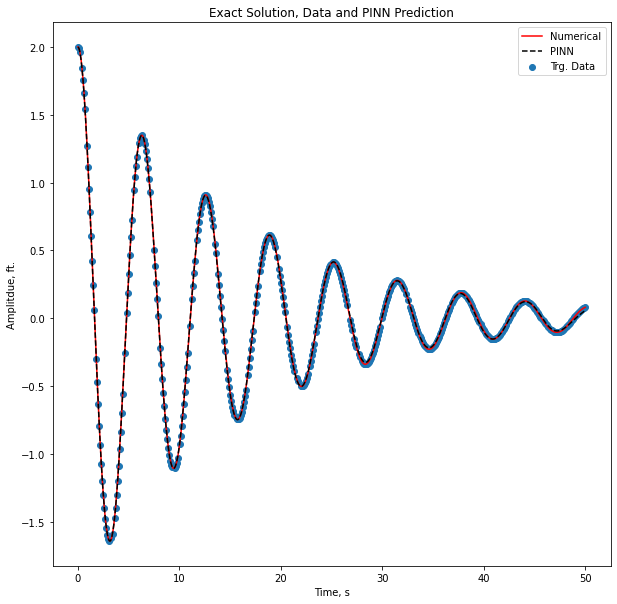

In [25]:
#Plot PINN Performance against Numerical Solution and Training Data
plt.subplots(figsize=(10, 10))
plt.plot(t, sol.y[0], 'r', label='Numerical')
plt.plot(t_eval,u_eval, '--k', label='PINN')
plt.scatter(t_train, u_train, label='Trg. Data')
plt.legend()
plt.xlabel('Time, s')
plt.ylabel('Amplitdue, ft.')
plt.title('Exact Solution, Data and PINN Prediction')
plt.plot()